<font size="5">Fashion-MNIST Multilayer Perceptron (TensorFlow)</font>

<u>Upcoming<u/>
- Improve Performance
  - Utilize automatic differentiation support for tensor containers
  - Build and compare alternative models (e.g., deeper model with neuron dropout; simpler model); evaluate effect on performance
  - Tune hyperparameters (e.g., learning rate scheduling, neuron dropout rate)
  - Display performance metrics in confusion matrix; reduce error rate


<br />

<u>Quick Notes<u/>
- Dataset contains 70,000 grayscale images of fashion items across 10 categories/classes, with information stored at the pixel level
  - Image dimensions are 28*28 pixels (784 total)
  - Data features consist of 784 pixel brightnesses (ranging from 0-255), with no colour (RGB/RGBA) information.
  - Data labels contain the true classification of each instance (integer encoding, 0-9).
- Since there is no emphasis on classifying any label in particular, and the full dataset conveniently includes equal proportions of all labels, train/validation/test sets are created with equal (stratified) proportions of instance labels.

In [2]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
from pathlib import Path
from time import strftime
import datetime
import random

%load_ext tensorboard

Section 1: DataFrame Transformations

In [3]:
#Import full CSV data as DataFrame
fmnist_full = pd.read_csv(r'C:\Users\darkw\Desktop\f_mnist_full.csv')
print(fmnist_full.shape)
fmnist_full.head(2)

(70000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Verify dtypes
fmnist_full.dtypes[:5]

label     int64
pixel1    int64
pixel2    int64
pixel3    int64
pixel4    int64
dtype: object

In [5]:
#Establish indexed class list
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
#Sample 1a: Visualize record stored in full DataFrame
 #Select random df record
sample1a = fmnist_full.sample(1)
 #Output category from df
s1a_class = sample1a['label'].values[0]
print('Item clothing category:', class_names[s1a_class])
 #Preview index + attribute values
print(sample1a[['label','pixel18','pixel392','pixel750']])

Item clothing category: Ankle boot
       label  pixel18  pixel392  pixel750
61839      9        0        99        93


In [7]:
 #Store sample features
sample1a = sample1a.drop(sample1a[['label']], axis=1)
s1a_vals = sample1a.values[0]
 #Reshape features for visualization
s1a_img = s1a_vals.reshape(28, 28)

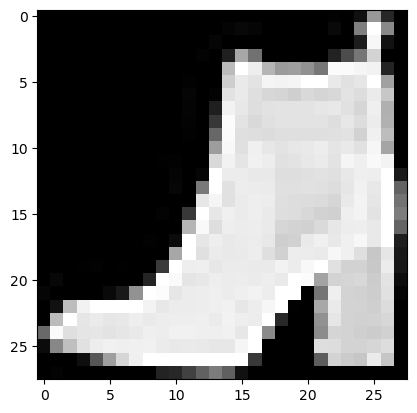

In [8]:
 #Display sample 1a in original cmap (grayscale)
plt.imshow(s1a_img, cmap='gray');

In [9]:
#Create target + feature dfs
y = fmnist_full['label']

X = fmnist_full.drop(fmnist_full[['label']], axis=1)
X.shape, y.shape

((70000, 784), (70000,))

In [10]:
#Review dataset balance
y.value_counts().sort_index()

label
0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: count, dtype: int64

In [11]:
#Convert target df to array
y = y.to_numpy()
y.shape

(70000,)

In [12]:
#Convert feature df to array + reshape for input layer
X_28 = X.to_numpy().reshape(70000, 28, 28)
X_28.shape

(70000, 28, 28)

Section 2: Array Transformations

In [13]:
#Sample 1b: Re-locate sample 1a in array; visualize to verify
 #Store 1a index value; output to verify
s1_index = sample1a.index
s1_index

Index([61839], dtype='int64')

In [14]:
 #Output category from label array
s1b_class = y[s1_index][0]

print('Item clothing category:', class_names[s1b_class])

Item clothing category: Ankle boot


In [15]:
 #Store feature values from reshaped array
sample1b = X_28[s1_index][0]
 #Display integer dtype/values
print(sample1b.dtype)
sample1b[0][0:40]

int64


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,  16, 152,
        39,   0], dtype=int64)

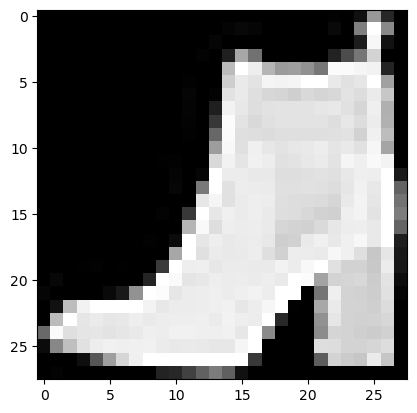

In [16]:
 #Display sample 1b in original cmap (grayscale)
plt.imshow(sample1b, cmap='gray');

In [17]:
#Split full dataset into 60,000 train + 10,000 test, maintaining label balance
X_train_full, X_te, y_train_full, y_te = train_test_split(X_28, y, test_size=1/7, stratify=y)

In [18]:
#Compare methods for creating validation set from training set
 #Keras training APIs include 'validation_split'; selects "the last samples in the x and y data provided, before shuffling"
  #Check last 5000 labels to evaluate would-be balance of validation set created by index slice/keras method
y_last5k = y_train_full[-5000:]

In [19]:
value1, count1 = np.unique(y_last5k, return_counts=True)

last5k_dict = dict(map(lambda label, freq : (label,freq) , value1, count1))

for i in last5k_dict:
    print(i, last5k_dict[i])

0 536
1 492
2 488
3 534
4 481
5 516
6 504
7 463
8 509
9 477


In [20]:
#Split training data into 55,000 train + 5,000 validation
 #Opting for sklearn 'train_test_split' to stratify by label, preserving label balance more precisely
X_train, X_valid, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=1/12, stratify=y_train_full)

In [21]:
#Verify balance
 #Count label frequencies by set
value2, count2 = np.unique(y_tr, return_counts=True)
value3, count3 = np.unique(y_val, return_counts=True)
value4, count4 = np.unique(y_te, return_counts=True)

In [22]:
 #Map and display dictionaries
  #Training label frequencies
label_dict1 = dict(map(lambda label, freq : (label,freq) , value2, count2))

for i in label_dict1:
    print(i, label_dict1[i])

0 5500
1 5500
2 5500
3 5500
4 5500
5 5500
6 5500
7 5500
8 5500
9 5500


In [23]:
  #Validation label frequencies
label_dict2 = dict(map(lambda label, freq : (label,freq) , value3, count3))

for i in label_dict2:
    print(i, label_dict2[i])

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [24]:
  #Test label frequencies
label_dict3 = dict(map(lambda label, freq : (label,freq) , value4, count4))

for i in label_dict3:
    print(i, label_dict3[i])

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


In [25]:
#Preview feature (pre-scaling) and label values from arrays
 #features
X_valid[:1][0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
 #label
y_val[:1]

array([7], dtype=int64)

In [27]:
#Scale feature arrays from 0-255 (int) to 0.0-1.0 (float)
X_tr_sc, X_val_sc, X_te_sc = X_train/255., X_valid/255., X_te/255.

Section 3: Tensor transformations

In [28]:
#Convert feature + label sets to tensors; reduce respective precisions
X_tr_sc = tf.convert_to_tensor(X_tr_sc, dtype=tf.float32)
X_val_sc = tf.convert_to_tensor(X_val_sc, dtype=tf.float32)
X_te_sc = tf.convert_to_tensor(X_te_sc, dtype=tf.float32)

y_tr = tf.convert_to_tensor(y_tr, dtype=tf.int8)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int8)
y_te = tf.convert_to_tensor(y_te, dtype=tf.int8)

In [29]:
 #Verify shapes
print(X_tr_sc.shape, y_tr.shape)
print(X_val_sc.shape, y_val.shape)
print(X_te_sc.shape, y_te.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [30]:
#Sample 2: Visualize post-splits, post-scaling sample from tensor
sample2 = X_tr_sc[0]
 #Verify transformation of features to float dtype; preview values
print(sample2.dtype)
sample2[27]

<dtype: 'float32'>


<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [31]:
 #Output sample label + category from tensor
print(y_tr[0])

s2_class = y_tr[0]
print(class_names[s2_class])

tf.Tensor(7, shape=(), dtype=int8)
Sneaker


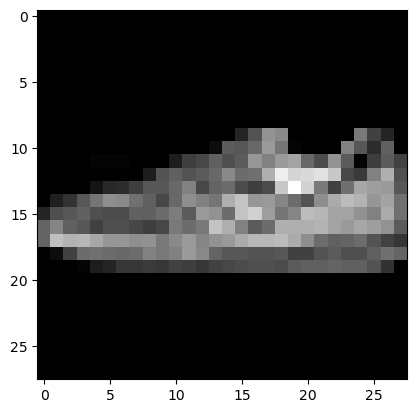

In [32]:
 #Display sample 2
plt.imshow(sample2, cmap='gray');

Section 4: Model Building, Training & Storage

In [33]:
#TensorBoard log directory setup
log_dir = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Define callbacks
 #Event log callback
event_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
 #Model checkpoint callback
checkp_cb = tf.keras.callbacks.ModelCheckpoint("DNN1 Checkpoints", save_best_only=True)
 #Early stopping callback
stop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=20)
 #Bundle
cb_list = [event_cb, checkp_cb, stop_cb]

In [35]:
#Build Network 1
 #2 Hidden layers (300 * 100 nodes)
dnn1 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(300, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
#Preview initialized weights and biases
layer_100node = dnn1.layers[2]
layer_100node.name

'dense_4'

In [37]:
weights_100, biases_100 = layer_100node.get_weights()
print(weights_100.shape)
weights_100

(300, 100)


array([[ 0.00272415,  0.05719789,  0.03246147, ...,  0.06418929,
        -0.07260534,  0.08686655],
       [ 0.09805641,  0.08955988, -0.00674577, ...,  0.09933286,
         0.10939758,  0.11046628],
       [-0.09323867,  0.07217091,  0.06213035, ...,  0.07606489,
         0.08526821,  0.0796096 ],
       ...,
       [ 0.03215899, -0.07936785, -0.09723617, ...,  0.11796408,
         0.00672842, -0.0876195 ],
       [-0.11170729,  0.1191553 ,  0.10861313, ..., -0.08256477,
         0.04747724,  0.01219543],
       [ 0.00330634,  0.02402749,  0.1057163 , ..., -0.09593437,
        -0.00684111, -0.10132154]], dtype=float32)

In [38]:
print(biases_100.shape)
biases_100

(100,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [39]:
#Configure optimizer, loss function & performance metric
optimizer1 = tf.keras.optimizers.SGD() #default: 0.01

dnn1.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer1,
                   metrics=['accuracy'])

In [41]:
#Train network + store results
epoch_count = 50
history1 = dnn1.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list, verbose=2)

Epoch 1/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.4661 - accuracy: 0.8365 - val_loss: 0.4520 - val_accuracy: 0.8406 - 3s/epoch - 2ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.4358 - accuracy: 0.8462 - val_loss: 0.4380 - val_accuracy: 0.8466 - 3s/epoch - 2ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.4108 - accuracy: 0.8564 - val_loss: 0.4009 - val_accuracy: 0.8586 - 3s/epoch - 2ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3926 - accuracy: 0.8619 - val_loss: 0.3846 - val_accuracy: 0.8678 - 3s/epoch - 2ms/step
Epoch 5/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3783 - accuracy: 0.8666 - val_loss: 0.3818 - val_accuracy: 0.8664 - 3s/epoch - 2ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3659 - accuracy: 0.8708 - val_loss: 0.3710 - val_accuracy: 0.8712 - 3s/epoch - 2ms/step
Epoch 7/50
1719/1719 - 2s - loss: 0.3551 - accuracy: 0.8747 - val_loss: 0.3793 - val_accuracy: 0.8668 - 2s/epoch - 1ms/step
Epoch 8/50
1719/1719 - 3s - loss: 0.3445 - accuracy: 0.8777 - val_loss: 0.3734 - val_accuracy: 0.8716 - 3s/epoch - 1ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3362 - accuracy: 0.8815 - val_loss: 0.3700 - val_accuracy: 0.8678 - 3s/epoch - 2ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3275 - accuracy: 0.8837 - val_loss: 0.3565 - val_accuracy: 0.8756 - 3s/epoch - 2ms/step
Epoch 11/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3207 - accuracy: 0.8849 - val_loss: 0.3466 - val_accuracy: 0.8766 - 3s/epoch - 2ms/step
Epoch 12/50
1719/1719 - 2s - loss: 0.3134 - accuracy: 0.8888 - val_loss: 0.3526 - val_accuracy: 0.8786 - 2s/epoch - 1ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3072 - accuracy: 0.8907 - val_loss: 0.3319 - val_accuracy: 0.8864 - 3s/epoch - 2ms/step
Epoch 14/50
1719/1719 - 2s - loss: 0.2996 - accuracy: 0.8925 - val_loss: 0.3386 - val_accuracy: 0.8782 - 2s/epoch - 1ms/step
Epoch 15/50
1719/1719 - 2s - loss: 0.2939 - accuracy: 0.8942 - val_loss: 0.3526 - val_accuracy: 0.8712 - 2s/epoch - 1ms/step
Epoch 16/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2887 - accuracy: 0.8963 - val_loss: 0.3291 - val_accuracy: 0.8854 - 3s/epoch - 2ms/step
Epoch 17/50
1719/1719 - 3s - loss: 0.2818 - accuracy: 0.8972 - val_loss: 0.3319 - val_accuracy: 0.8820 - 3s/epoch - 1ms/step
Epoch 18/50
1719/1719 - 2s - loss: 0.2776 - accuracy: 0.8987 - val_loss: 0.3369 - val_accuracy: 0.8800 - 2s/epoch - 1ms/step
Epoch 19/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2719 - accuracy: 0.9016 - val_loss: 0.3190 - val_accuracy: 0.8866 - 3s/epoch - 2ms/step
Epoch 20/50
1719/1719 - 2s - loss: 0.2683 - accuracy: 0.9027 - val_loss: 0.3209 - val_accuracy: 0.8834 - 2s/epoch - 1ms/step
Epoch 21/50
1719/1719 - 2s - loss: 0.2631 - accuracy: 0.9035 - val_loss: 0.3229 - val_accuracy: 0.8888 - 2s/epoch - 1ms/step
Epoch 22/50
1719/1719 - 2s - loss: 0.2582 - accuracy: 0.9058 - val_loss: 0.3271 - val_accuracy: 0.8828 - 2s/epoch - 1ms/step
Epoch 23/50
1719/1719 - 2s - loss: 0.2532 - accuracy: 0.9094 - val_loss: 0.3334 - val_accuracy: 0.8828 - 2s/epoch - 1ms/step
Epoch 24/50
1719/1719 - 3s - loss: 0.2488 - accuracy: 0.9094 - val_loss: 0.3430 - val_accuracy: 0.8754 - 3s/epoch - 1ms/step
Epoch 25/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2455 - accuracy: 0.9101 - val_loss: 0.3054 - val_accuracy: 0.8912 - 3s/epoch - 2ms/step
Epoch 26/50
1719/1719 - 2s - loss: 0.2412 - accuracy: 0.9127 - val_loss: 0.3068 - val_accuracy: 0.8954 - 2s/epoch - 1ms/step
Epoch 27/50
1719/1719 - 2s - loss: 0.2373 - accuracy: 0.9138 - val_loss: 0.3060 - val_accuracy: 0.8944 - 2s/epoch - 1ms/step
Epoch 28/50
1719/1719 - 2s - loss: 0.2334 - accuracy: 0.9163 - val_loss: 0.3312 - val_accuracy: 0.8830 - 2s/epoch - 1ms/step
Epoch 29/50
1719/1719 - 2s - loss: 0.2304 - accuracy: 0.9165 - val_loss: 0.3185 - val_accuracy: 0.8882 - 2s/epoch - 1ms/step
Epoch 30/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2263 - accuracy: 0.9185 - val_loss: 0.3017 - val_accuracy: 0.8970 - 3s/epoch - 2ms/step
Epoch 31/50
1719/1719 - 2s - loss: 0.2224 - accuracy: 0.9195 - val_loss: 0.3058 - val_accuracy: 0.8946 - 2s/epoch - 1ms/step
Epoch 32/50
1719/1719 - 2s - loss: 0.2189 - accuracy: 0.9211 - val_loss: 0.3116 - val_accuracy: 0.8892 - 2s/epoch - 1ms/step
Epoch 33/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2153 - accuracy: 0.9221 - val_loss: 0.2993 - val_accuracy: 0.8978 - 3s/epoch - 2ms/step
Epoch 34/50
1719/1719 - 2s - loss: 0.2116 - accuracy: 0.9237 - val_loss: 0.3224 - val_accuracy: 0.8912 - 2s/epoch - 1ms/step
Epoch 35/50
1719/1719 - 2s - loss: 0.2099 - accuracy: 0.9237 - val_loss: 0.3147 - val_accuracy: 0.8896 - 2s/epoch - 1ms/step
Epoch 36/50
1719/1719 - 2s - loss: 0.2069 - accuracy: 0.9250 - val_loss: 0.3141 - val_accuracy: 0.8904 - 2s/epoch - 1ms/step
Epoch 37/50
1719/1719 - 2s - loss: 0.2028 - accuracy: 0.9277 - val_loss: 0.3010 - val_accuracy: 0.8958 - 2s/epoch - 1ms/step
Epoch 38/50
1719/1719 - 2s - loss: 0.1999 - accuracy: 0.9273 - val_loss: 0.3046 - val_accuracy: 0.8956 - 2s/epoch - 1ms/step


In [42]:
#Save best model
dnn1.save("best_dnn1", save_format="tf")

INFO:tensorflow:Assets written to: best_dnn1\assets


INFO:tensorflow:Assets written to: best_dnn1\assets


Section 5: Predictive Performance Analysis

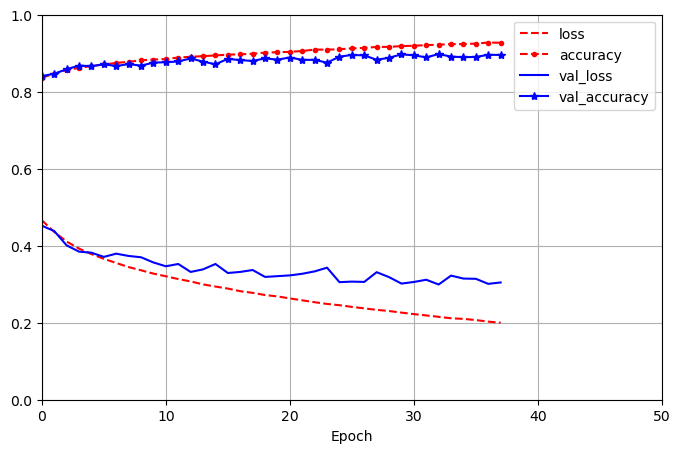

In [43]:
#Visualize learning curves manually
dnn1_learn_curves = pd.DataFrame(history1.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'])
plt.show()

In [47]:
#Display learning curves in TensorBoard
%tensorboard --logdir tensorboard_logs/fit

TensorBoard UI: validation accuracies/losses visualized by run, with comparison tooltip (screencap; does not function in GitHub)
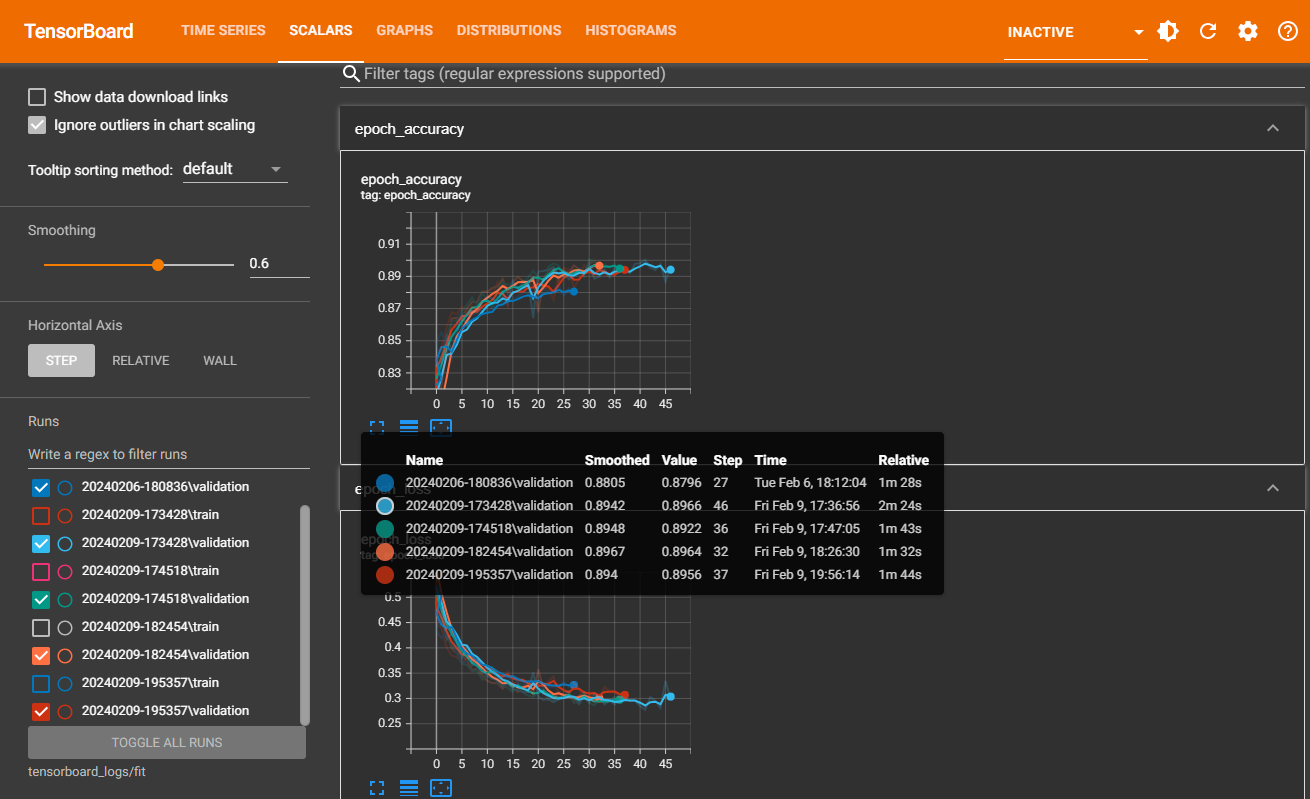

In [49]:
#Load best model for evaluation
best_dnn1 = tf.keras.models.load_model("best_dnn1")

In [50]:
#Evaluate best model on test set
best_dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 997us/step - loss: 0.3070 - accuracy: 0.8945


[0.3070251941680908, 0.8945000171661377]

In [51]:
#Verify result with original / non-loaded model
dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 983us/step - loss: 0.3070 - accuracy: 0.8945


[0.3070251941680908, 0.8945000171661377]

In [52]:
#Generate + store predictions from model
preds1 = best_dnn1.predict(X_te_sc)

313/313 [==============================] - 0s 871us/step


In [53]:
#Review shapes for test label+prediction arrays
 #Prediction array includes one probability per class, for each instance
print(y_te.shape, preds1.shape)
print('Example classwise probabilities:')
pd.DataFrame({'Probabilities': preds1[0]})

(10000,) (10000, 10)
Example classwise probabilities:


,Probabilities
0,1.731305e-06
1,8.190314e-07
2,2.940592e-01
3,1.721749e-07
4,6.901819e-01
5,1.288238e-10
6,1.574967e-02
7,4.582729e-08
8,6.535024e-06
9,1.076150e-09


Instance #: 5215/10,000
True class of instance: tf.Tensor(9, shape=(), dtype=int8) (Ankle boot)
Predicted class of instance: 9 (Ankle boot)
Model's confidence in prediction: 0.999526
AxesImage(shape=(28, 28))


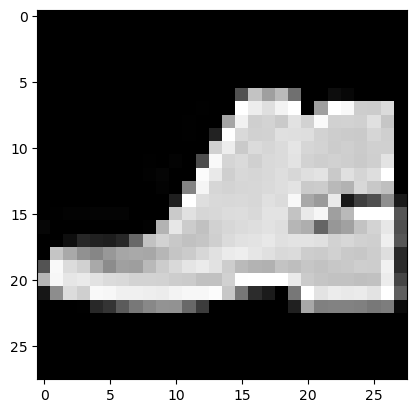

In [54]:
#Sample 3: Compare actual and predicted class for random prediction set instance
 #Select index value for sample
instance_val = random.randint(0,10000)

 #Store values
sample4 = X_te_sc[instance_val]
s4_class_true = y_te[instance_val]
s4_class_pred = np.argmax(preds1[instance_val])
s4_conf = max(preds1[instance_val])

 #Output instance #, true class, predicted class, and prediction confidence for sample
print('Instance #: '+str(instance_val+1)+'/10,000')
print('True class of instance: '+str(s4_class_true)+' ('+class_names[s4_class_true]+')')
print('Predicted class of instance: '+str(s4_class_pred)+' ('+class_names[s4_class_pred]+')')
print('Model\'s confidence in prediction: '+str(s4_conf))

#Display sample 4 image
print(plt.imshow(sample4, cmap='gray'));

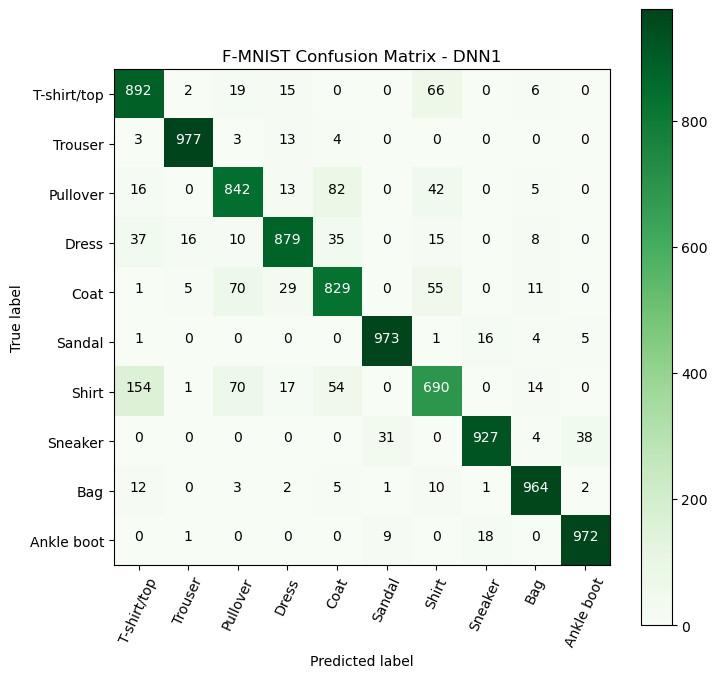

In [55]:
#Confusion Matrix 1: Predictions (non-normalized)
 #manual method
confusion_matrix1 = confusion_matrix(y_te, np.argmax(preds1, axis=1))

plt.figure(figsize=(8,8))
plt.imshow(confusion_matrix1, cmap='Greens')
plt.title('F-MNIST Confusion Matrix - DNN1')
plt.colorbar()
plt.xticks(np.arange(10), class_names, rotation=65)
plt.yticks(np.arange(10), class_names)

for i, j in product(range(confusion_matrix1.shape[0]), range(confusion_matrix1.shape[1])):
    plt.text(j, i, confusion_matrix1[i, j],
    horizontalalignment="center",
    color="white" if confusion_matrix1[i, j] > 500 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label');

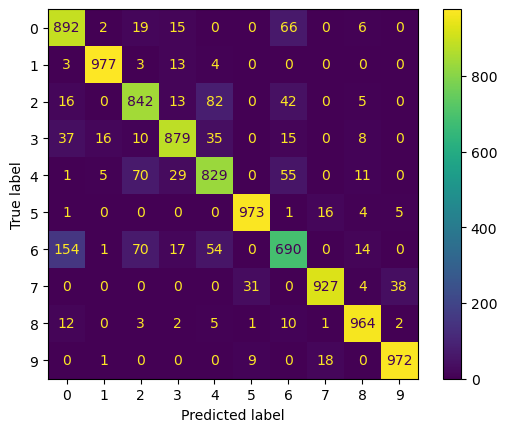

In [56]:
#Confusion matrix 2: Predictions (non-normalized)
 #ConfusionMatrixDisplay method
confusion_matrix2 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1))
plt.show()

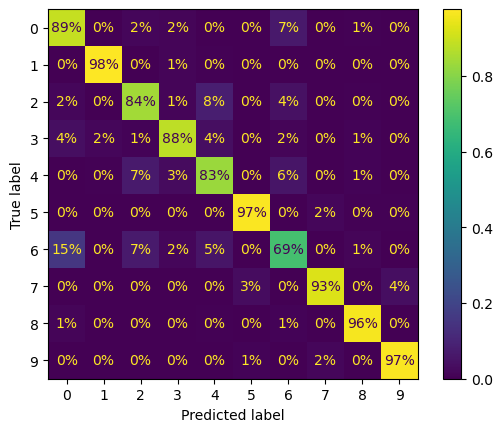

In [57]:
#Confusion matrix 3: Predictions (normalized by row)
confusion_matrix3 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='true')
plt.show()

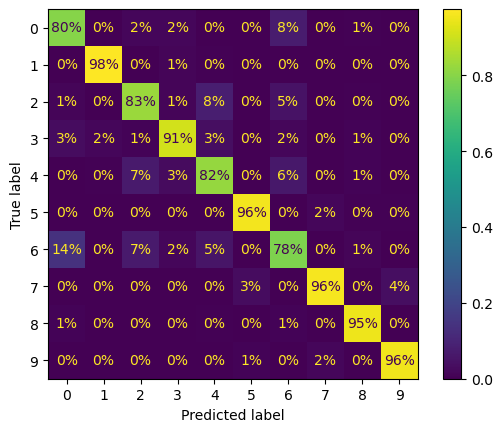

In [58]:
#Confusion matrix 4: Predictions (normalized by column)
confusion_matrix4 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='pred')
plt.show()

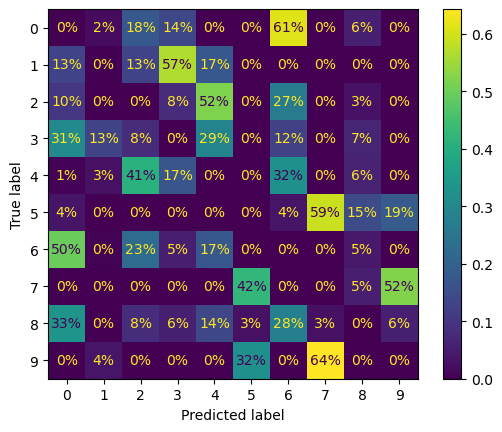

In [59]:
#Confusion matrix 5: Errors (normalized by row)
sample_weights = (np.argmax(preds1, axis=1) != y_te)

confusion_matrix5 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='true', sample_weight=sample_weights)
plt.show()

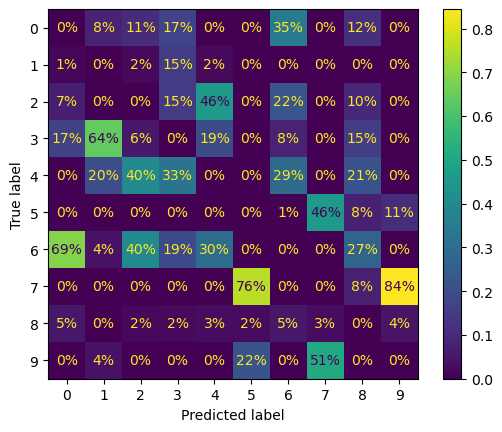

In [60]:
#Confusion matrix 6: Errors (normalized by column)
confusion_matrix5 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='pred', sample_weight=sample_weights)
plt.show()